In [7]:
import os
import glob
import gpxpy
import json

import requests
import polyline
import itertools

import pandas as pd

import matplotlib.pyplot as plt
import contextily as ctx

import xml.dom.minidom
from xml.etree.ElementTree import Element, SubElement, tostring

from geopy.distance import geodesic

In [8]:
DEFAULT_RADIUS_IN_METERS = 10

In [17]:
def osrm_format(coords):
    lat, lon = coords
    return f"{lon},{lat}"

def get_route(points):
    points = ';'.join(map(osrm_format, points))
    params = {
        'geometries': 'polyline6',
    }
    
    response = requests.get(f"http://127.0.0.1:6000/route/v1/foot/{points}", params=params)
    routes = response.json()
    
    if routes['code'] != 'Ok':
        print(routes)
        return None
    
    geometry = routes['routes'][0]['geometry']
    return polyline.decode(geometry, 6)

def get_match(points):
    radiuses = ';'.join([str(DEFAULT_RADIUS_IN_METERS)] * len(points))
    points = ';'.join(map(osrm_format, points))
    
    params = {
        'geometries': 'polyline6',
        'radiuses': radiuses,
    } 
    response = requests.get(f"http://127.0.0.1:6000/match/v1/foot/{points}", params=params)
    routes = response.json()
    
    if routes['code'] != 'Ok':
        print(routes)
        return None
    
    route = [
        polyline.decode(matching['geometry'], 6) 
        if matching['confidence'] > 0.90
        else []
        for matching in routes['matchings']
    ]

    return list(itertools.chain.from_iterable(route))

def plot_gpx(df, ax, color, label):
    ax.plot(df['lon'], df['lat'], color=color, label=label)
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    ax.legend()
    ax.set_yticks([])
    ax.set_xticks([])
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

def parse_gpx(filepath):
    gpx_file = open(filepath, 'r')
    gpx = gpxpy.parse(gpx_file)

    data = []

    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat, lon = point.latitude, point.longitude,
                data.append({
                  'lat': lat, 
                  'lon': lon,
                })

    df = pd.DataFrame(data)

    return df    
    
def create_gpx(route, filename):
    gpx = Element('gpx', {
        'creator': 'Evgeny Arbatov',
        'xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
        'xsi:schemaLocation': 'http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd',
        'version': '1.1',
        'xmlns': 'http://www.topografix.com/GPX/1/1'
    })
    trk = SubElement(gpx, "trk")
    trkseg = SubElement(trk, "trkseg")

    for lat, lng in route:
        SubElement(trkseg, "trkpt", attrib={"lat": str(lat), "lon": str(lng)})

    gpx = xml.dom.minidom.parseString(
        tostring(gpx, encoding="unicode")
    ).toprettyxml() 
        
    with open(filename, "w") as f:
        f.write(gpx)

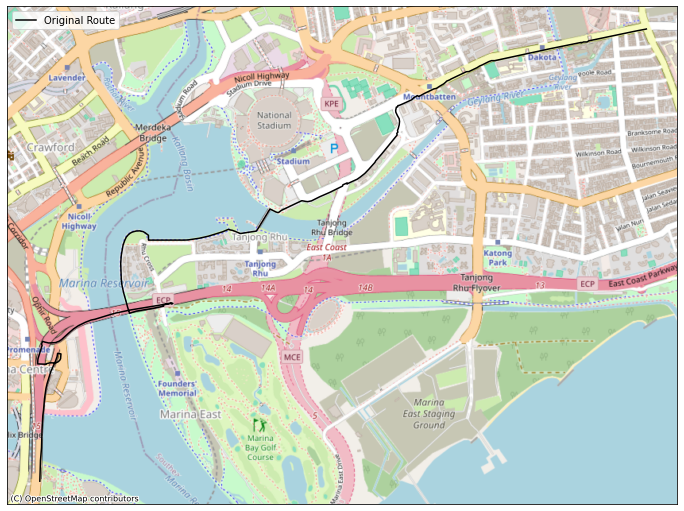

In [18]:
df = parse_gpx('../singapore/benjamin-sheares-bridge/original-route.gpx')
fig, ax = plt.subplots(1, 1, figsize=(12, 30))
plot_gpx(df, ax, 'black', 'Original Route')
plt.show()

In [11]:
points = list(zip(df['lat'].tolist(), df['lon'].tolist()))

complete_route = []

for (_, row1), (_, row2) in zip(df.iterrows(), df.iloc[1:].iterrows()):
    matched_route = get_match([
        (row1['lat'], row1['lon']),
        (row2['lat'], row2['lon']),
    ])
    complete_route.append(matched_route)

complete_route = list(itertools.chain.from_iterable(complete_route))
create_gpx(complete_route, '../singapore/benjamin-sheares-bridge/route.gpx')

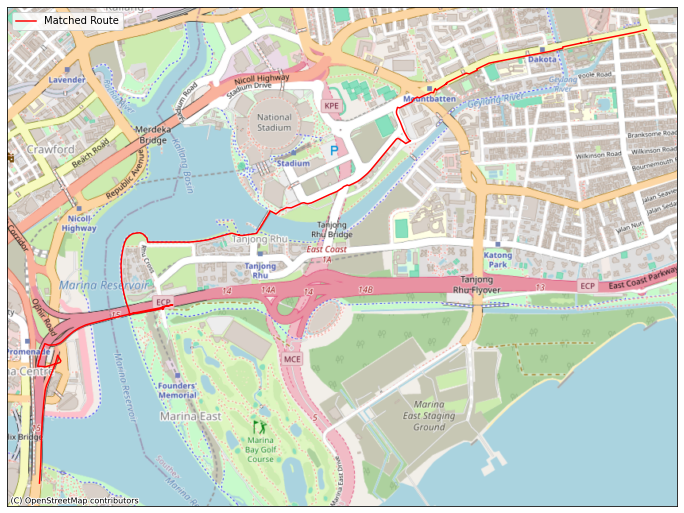

In [15]:
df = parse_gpx('../singapore/benjamin-sheares-bridge/route.gpx'')
fig, ax = plt.subplots(1, 1, figsize=(12, 30))
plot_gpx(df, ax, 'red', 'Matched Route')
plt.show()